# Uplift modeling

U ovoj svesci ćemo prikazati primenu 2 pristupa modelovanja uzdizanja koje smo opisali:
- pristup 2 modela (Two Models Approach)
- pristup transformacije klasa (Class Transformation approach)

Podaci koji se koriste su opisani u propratnom fajlu koji se nalazi na istom Github repozitorijumu. Cilj je da se može predvideti porast, to je razlika verovatnoće u ishodu koju generiše tretman za svaku osobu.

In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Učitavanje podataka

In [3]:
#load dataset
df=pd.read_csv("customer_simulation.csv")
df.shape

(10000, 24)

In [4]:
df.head()

,customer_id,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,Node9,...,Node14,Node15,customer_type,Node17,Node18,Node19,Node20,target_control,outcome,train_test
0,1,Value4,Value1,Value2,Value2,Value2,Value4,Value2,Value4,Value4,...,Value3,Value3,persuadable,Value2,Value2,Value3,Value1,control,0,train
1,2,Value2,Value1,Value1,Value2,Value3,Value4,Value2,Value2,Value4,...,Value1,Value1,sleeping_dog,Value3,Value3,Value1,Value4,control,1,test
2,3,Value2,Value2,Value1,Value3,Value2,Value1,Value2,Value4,Value3,...,Value2,Value3,lost_cause,Value2,Value3,Value2,Value4,target,0,train
3,4,Value3,Value1,Value1,Value2,Value3,Value4,Value4,Value1,Value4,...,Value2,Value1,persuadable,Value2,Value3,Value1,Value4,control,0,train
4,5,Value4,Value1,Value1,Value3,Value2,Value1,Value2,Value4,Value3,...,Value3,Value2,sleeping_dog,Value1,Value3,Value2,Value4,control,1,train


Ovaj skup podataka sadrzi podatke o 10000 klijenata. Detaljna objasnjenja kolona i njihove kategorije su opisane u propratnom fajlu.
Varijable na koje cemo se fokusirati za potrebe ovog problema su: 'customer_type' (tip klijenta), 'target_control' (klijent je primio ili nije primio tretman), 'outcome' (ciljna promenljiva koju smo definisali unapred), 'train_test' (podela skupa podataka na trening i test skup).
Svaki red predstavlja klijenta koji može pripadati jednoj od 4 kategorije:
- **persuadable** (ubedljiva osoba - kupiće proizvod ako je kontaktiramo. Ovo je tip osobe koju želimo da targetiramo sa modelom uzdizanja.)
- **lost cause** (osoba koja sigurno neće kupiti proizvod, nevezano da li je tretirana ili nije)
- **sleeping dog** (osoba koja neće kupiti proizvod ako je kontaktiramo. Primer je osoba koja ima mesečnu supskripciju na teretanu koju ne koristi, i dobije email od teretane. Kontaktiranje ovih osoba je loše za biznis.)
- **sure_thing** (osoba koja bi sigurno kupila proizvod bez obzira da li je kontaktirana. Targetiranje ovih osoba je nepotrebno zbog troškova kontaktiranja.)

In [7]:
from IPython.display import Image
img = 'Sleepingdog.png'
Image(url=img)

In [5]:
#customers are balanced based on customer type

df.customer_type.value_counts()

lost_cause      2554
sleeping_dog    2528
persuadable     2471
sure_thing      2447
Name: customer_type, dtype: int64

Takođe svaki od klijenata može pripadati tretiranoj grupi ili kontrolnoj grupi. Tretirana osoba je primila neku vrstu akcije od banke (primila je email sa ponudom ili je bila kontaktirana). Osobe iz kontrolne grupe nisu primile nikakav tretman/akciju od banke. Podela je balansirana izmedju ove dve grupe.

In [6]:
df.target_control.value_counts()

control    5063
target     4937
Name: target_control, dtype: int64

Cilj ovog primera je da predvidimo odliv tj *churn*. Vrednost u koloni outcome je binarna tj 0/1 i predstavlja 1 - ako osoba nece otići iz banke i 0 ako će osoba otići iz banke.

In [8]:
df.outcome.value_counts()

0    5047
1    4953
Name: outcome, dtype: int64

Podaci su unapred pripremljeni i podeljeni u trening i test skup u proporciji 80/20.

In [9]:
df.train_test.value_counts()

train    7952
test     2048
Name: train_test, dtype: int64

Ostalih 19 kolona su kategoricke varijable koje mogu da se koriste da se predvidi ciljna varijabla ili efekat uzdizanja za svaku osobu.

U datasetu je kolona target_control veštački napravljena, ali u stvarnom primeru, ostale varijable bi se koristile u modelu za predviđanje i na osnovu predvidjene vrednosti uplifta uz dogovoreni treshlod bi se definisala kategorizacija klijenata. 

### Dummy varijable
Kategoricke varijable se prevode u numericke.

In [11]:
# dummify

feat = [x  for x in df.columns if "Node" in x]

features = []
for f in feat : 
    dummies = pd.get_dummies(df[f]).rename(columns=lambda x: f + "_" + str(x))
    features = features + list(dummies.columns)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([f], axis=1)
    print ("done", f)

done Node1
done Node2
done Node3
done Node4
done Node5
done Node6
done Node7
done Node8
done Node9
done Node10
done Node11
done Node12
done Node13
done Node14
done Node15
done Node17
done Node18
done Node19
done Node20


In [13]:
train_df = df[df["train_test"]=="train"] 
test_df = df[df["train_test"]=="test"] 

print (train_df.shape)
print (test_df.shape)

(7952, 81)
(2048, 81)


## Pristup 2 modela (Two Models Approach)

Modeliramo efekat povećanja *uplift* računajući razliku između verovatnoće ishoda u tretiranom skupu podataka minus verovatnoću ishoda u kontrolnom skupu podataka.

In [14]:
target = train_df[train_df["target_control"]=='target']  
control = train_df[train_df["target_control"]=='control']

print (target.shape)
print (control.shape)

(3934, 81)
(4018, 81)


In [15]:
target_X = target[features]
control_X = control[features]

target_Y = target[['outcome']]
control_Y = control[['outcome']]

test_X = test_df[features]

#### Treniranje
Koristimo 2 odvojena modela za tretiranu i kontrolnu grupu.

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

clf1 = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1,max_depth = 3)
clf2 = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1,max_depth = 3)

In [17]:
clf1.fit(target_X.values,target_Y.values.ravel())
clf2.fit(control_X.values,control_Y.values.ravel())

GradientBoostingClassifier()

#### Skoring

In [18]:
test_df["proba_outcome_target"] = clf1.predict_proba(test_X)[:,1]
test_df["proba_outcome_control"] = clf2.predict_proba(test_X)[:,1]

# uplift is just the difference. 
test_df["uplift_1"] = test_df["proba_outcome_target"] - test_df["proba_outcome_control"] 

In [19]:
test_df['uplift_1']

1      -0.269375
8       0.067121
17      0.293496
22      0.031485
27     -0.261959
          ...   
9986   -0.249144
9990   -0.316335
9993   -0.254017
9995   -0.188545
9998    0.068185
Name: uplift_1, Length: 2048, dtype: float64

## Pristup transformacije klasa (Class Modification Approach)

Ovo implementiramo za pristup transformacije klasa:
- složimo tretirane i kontrolne podatke
- obrnemo target za kontrolne podatke
- obučimo model na ovakvom targetu
- efekat uzdizanja (uplift) se računa po dokazanoj formuli kao 2 puta predviđene verovatnoće -1

In [20]:
train_df['istarget'] = train_df['target_control'].map(lambda x : 1 if x=='target' else 0)
train_df['modified_outcome'] = train_df['outcome'] * train_df['istarget'] \
                                 + (1-train_df['outcome'])*(1-train_df['istarget'])

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 500,max_depth=10)

In [22]:
clf.fit(train_df[features].values, train_df['modified_outcome'].values.ravel())

RandomForestClassifier(max_depth=10, n_estimators=500)

In [23]:
test_df["uplift_2"] = 2*clf.predict_proba(test_X)[:,1] -1

In [24]:
test_df['uplift_2']

1      -0.147862
8       0.012853
17      0.117738
22      0.072947
27     -0.071591
          ...   
9986   -0.212495
9990   -0.162842
9993   -0.245880
9995   -0.072158
9998   -0.067871
Name: uplift_2, Length: 2048, dtype: float64

## Čuvamo rezultate predviđanja

In [25]:
test_df.to_csv("uplift_predictions.csv")

------------------------------------------------------

# Evaluacija i poređenje modela

U ovom delu sveske prikazaćemo poređenje prikazanih pristupa za modelovanje uzdizanja.

* Prvo ćemo izračunati vrednosti efekta uzdizanja i predstaviti njihovu raspodelu
* Onda ćemo pogledati predviđeno povećanje u poređenju sa latentnom promenljivom - tip klijenta
* Najzad ćemo uporediti dva pristupa:
    - posmatrajući porast po decilu ciljane populacije
    - poređenjem njihovih Qini kriva

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
import warnings
warnings.filterwarnings('ignore')
#import dataiku
#from dataiku import pandasutils as pdu
import pandas as pd
import seaborn

## Distribucije predviđenih vrednosti

#### Pristup 2 modela

In [29]:
df = pd.read_csv("uplift_predictions.csv")

Predstavićemo distribuciju predviđenih verovatnoća.

Text(0.5, 0.98, 'Predicted probability in case and control')

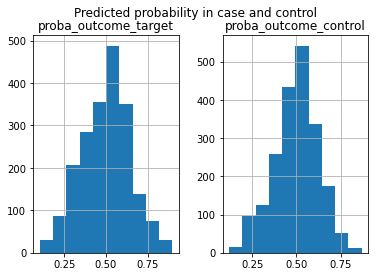

In [30]:
df[["proba_outcome_target","proba_outcome_control"]].hist()
plt.suptitle("Predicted probability in case and control")

Pošto modeli nisu baš dobri, distribucija verovatnoća izgleda kao Gausova sa centrom na 0.5. Da bismo izračunali efekat uzdizanja, samo ćemo izračunati razliku između te dve verovatnoće.

<AxesSubplot:title={'center':'Predicted uplift distribution'}>

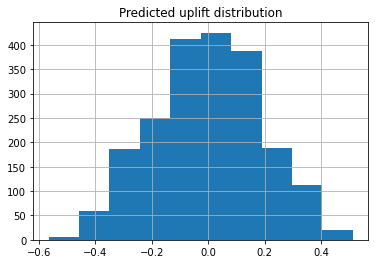

In [31]:
df["uplift_1"] = df['proba_outcome_target'] - df['proba_outcome_control']

plt.title("Predicted uplift distribution")
df["uplift_1"].hist()

Ovakva distribucija je očekivana pošto je dataset izbalansiran gledajući tip klijenta (varijablu).

#### Pristup modifikacije klasa

Da bismo izračunali uplift, morali smo samo da pomnožimo sa dva predviđenu verovatnoću i uklonimo 1.

<AxesSubplot:title={'center':'Predicted uplift distribution'}>

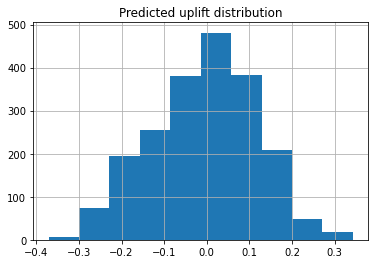

In [32]:
plt.title("Predicted uplift distribution")
df["uplift_2"].hist()

Distribucija deluje slično sa malo većim granicama.

## Evaluacija modela

### Bazirano na tipu klijenta

Prvi način da se procene i uporede modeli je da se pogledaju njihova prosečna predviđanja za svaki od 4 segmenta tipa klijenata.

Savršen model bi imao:
- uplift = 1 za kategoriju *persuadable*
- uplift = -1 za kategoriju *sleeping dog*
- uplift = 0 za kategoriju *sure thing* i *lost cause*

In [33]:
df.groupby("customer_type")[["uplift_1","uplift_2"]].mean()

,uplift_1,uplift_2
customer_type,,
lost_cause,-0.021835,-0.012276
persuadable,0.084970,0.052135
sleeping_dog,-0.097414,-0.065511
sure_thing,0.022166,-0.002915


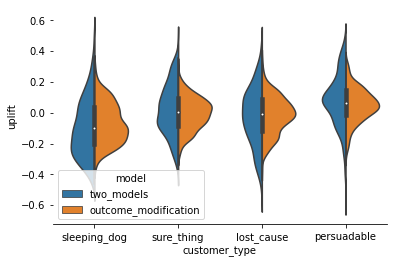

In [34]:
# Let's visualize this with a seaborn violin chart

tmp = df[["customer_type","uplift_1"]]
tmp.columns = ["customer_type",'uplift']
tmp["model"] = "two_models"

tmp1 = df[["customer_type","uplift_2"]]
tmp1.columns = ["customer_type",'uplift']
tmp1["model"] = "outcome_modification"

tmp = pd.concat([tmp,tmp1],axis=0)

seaborn.violinplot(x="customer_type", y="uplift", hue="model", data=tmp, split = True) 
seaborn.despine(left=True)

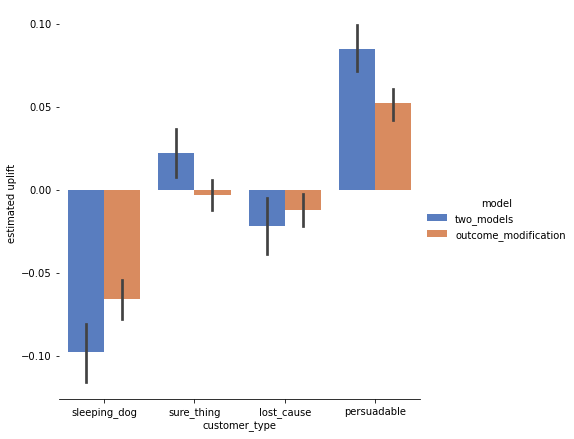

In [35]:
# to get clearer ideas, bar chart

g = seaborn.factorplot(x="customer_type", y="uplift", hue="model", data=tmp,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("estimated uplift")

Zaključci:
* Modeli ne izgledaju baš efikasni
* Gledajući kategoriju *persuadables* i *sleeping_dog* vidimo da se pristup dva modela čini malo boljim
* Na tip korisnika, na koji tretman ne bi trebalo da ima efekta, izgleda da pristup modifikacije klasa nadmašuje drugi.

## Evaluacija efekta uzdizanja (uplifta)

### Uplift po decilu

U ovom skupu podataka, pošto su tipovi kupaca izbalansirani, tretman nema globalni efekat. Ali šta ako bismo uredili stanovništvo smanjenjem predviđenog efekta uzdizanja (uplifta)?

Sa marketinške tačke gledišta, način da se proceni porast bi bio da se sortiraju kontrolna i tretirana grupa prema predviđenom efektu uzdizanja i izračuna stvarni porast za grupe verovatnoće tj. *bins* (primer: decil).

In [36]:
df['is_target'] = df['target_control'].map(lambda x : 1 if x == 'target' else 0)
df['perfect'] = df['outcome'] * df['is_target'] -  df['outcome'] * (1-df['is_target'])

In [40]:
def get_hist(mydf, upliftcol,targetcol,outcomecol,p = 10):
    
    """ calucate the uplift for each decile given an uplift prediction column
    """
    control = mydf[mydf[targetcol]==0]
    target = mydf[mydf[targetcol]==1]
    control.sort_values(upliftcol)
    target.sort_values(upliftcol)
    
    control["percentile"] =  floor(control[upliftcol].rank(method='first',ascending = False) / (control.shape[0]+1) * p)
    target["percentile"] =  floor(target[upliftcol].rank(method='first',ascending = False) / (target.shape[0]+1) * p)
    
    control = (control.groupby(["percentile"])[outcomecol].mean()).reset_index()
    control.columns = ["percentile", 'prob_control']
    
    target = (target.groupby(["percentile"])[outcomecol].mean()).reset_index()
    target.columns = ["percentile", 'prob_target']
    
    final = pd.merge(control,target, on = "percentile")
    final["uplift"] = final["prob_target"] - final["prob_control"]
    
    return final

Prikazaćemo uočeni efekat podizanja za predviđene grupe za pristup **dva modela**.

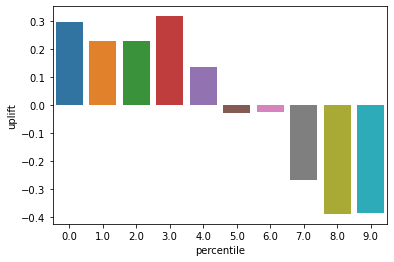

In [41]:
hist_twomod = get_hist(df, "uplift_1","is_target","outcome")
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

U odnosu na ovaj grafik možemo zaključiti da je ovaj model koristan jer se može smanjiti odliv *churn* za 30% u prvom decilu.

Prikazujemo grafik i za drugi pristup.

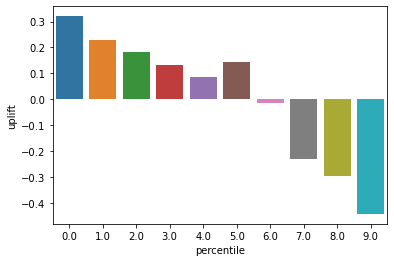

In [42]:
hist_twomod = get_hist(df, "uplift_2","is_target","outcome")
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

Čini se da ovaj model ima bolje rezultate ya prvih 10%, ali ako pogledamo prva tri decila, čini se da ne nadmašuje prvi pristup.

Ukoliko bismo želeli da prikažemo najbolji model - možemo ga dobiti kreiranjem lažne promenljive uplift efekta sa:
- veća vrednost na targetu ako je ishod 1 (konvertovan)
- niža vrednost na kontroli ako je ishod 1 (sure things)

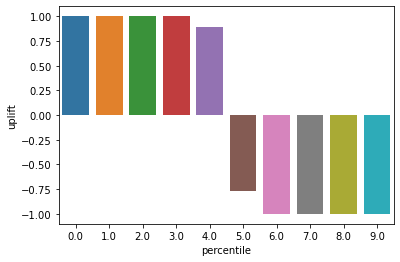

In [43]:
hist_twomod = get_hist(df, "perfect","is_target","outcome")
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

### Kumulativne grupe uplifta

Efekat uzdizanja za svaki bin/grupu je: $RT(t)/NT(t) - RC(t)/NC(t)$.
Gde je:
- RT(t) broj pozitivnih ishoda koji su tretirani
- RC(t) broj pozitivnih ishoda koji pripadaju kontrolnom skupu
- NT(t) broj tretiranih
- NC(t) broj klijenata u kontrolnom skupu

In [47]:
def get_hist_cum(df, upliftcol,targetcol, outcome_col,p=10) :
    
    tmp = df.copy()
    tmp = tmp.sort_values(upliftcol,ascending=False)
    tmp["percentile"] =  floor(tmp[upliftcol].rank(method='first',ascending = False) / (tmp.shape[0]+1) * p)
    
    final = []
    for val in range(p) :
        t = tmp[tmp['percentile']<=val]
        target = float(t[t[targetcol]==1][outcome_col].mean())
        control = float(t[t[targetcol]==0][outcome_col].mean())        
        uplift = (target - control) 
        final.append({'percentile':val,"uplift":uplift})
        
    return pd.DataFrame(final)

In [48]:
def get_hist_cum_2(df, upliftcol,targetcol, outcome_col,p=10) :
    
    tmp = df.copy()
    tmp = tmp.sort_values(upliftcol,ascending=False)
    tmp["percentile"] =  floor(tmp[upliftcol].rank(method='first',ascending = False) / (tmp.shape[0]+1) * p)
    
    final = []
    for val in range(p) :
        t = tmp[tmp['percentile']<=val]
        target = float(t[t[targetcol]==1][outcome_col].mean())
        control = float(t[t[targetcol]==0][outcome_col].mean())        
        uplift = (target - control) * t.shape[0]
        final.append({'percentile':val,"uplift":uplift})
        
    return pd.DataFrame(final)
    

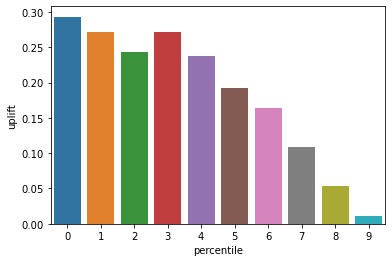

In [49]:
hist_twomod = get_hist_cum(df, "uplift_1","is_target","outcome",p=10)
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

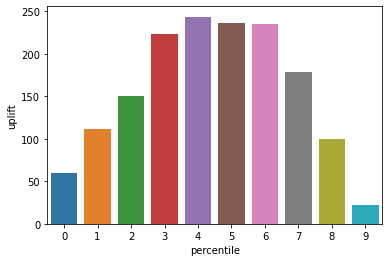

In [50]:
hist_twomod = get_hist_cum_2(df, "uplift_1","is_target","outcome",p=10)
ax = seaborn.barplot(hist_twomod["percentile"],hist_twomod['uplift'])

Ovu ideju možemo generalizovati tako što ćemo to izračunati za svaku tačku. Ovo bi nam dalo "krivu podizanja" (*uplift curve*).

### Kriva uzdizanja (Uplift curve)

Kriva uzdizanja je kriva parametrizovana sa t definisana kao $f(t) = (RT(t)/NT(t) - RC(t)/NC(t)) * NT(t)+NC(t)$.

Ideja je:
- Spojiti skup podataka za tretman i kontrolu
- Rasporediti prema predviđenom efektu uzdizanja u opadajućem poretku
- Evaluirati i proceniti sumu efekata uzdizanja za svaku tačku.

In [51]:
def uplift(df, target_control_col, outcome_col, proba_col) :
    
    tmp = df.copy()
    tmp = tmp.sort_values(proba_col,ascending=False)
    tmp['RT'] = (tmp[target_control_col]*tmp[outcome_col]).cumsum()
    tmp['RC'] = ((1-tmp[target_control_col])*tmp[outcome_col]).cumsum()
    tmp['NT'] = tmp[target_control_col].cumsum()
    tmp['NC'] = (1-tmp[target_control_col]).cumsum()
    tmp["upc_1"] =   ((tmp['RT']/tmp['NT']).fillna(0) - (tmp['RC']/tmp['NC']).fillna(0)) *(tmp['NC']+tmp['NT'])
    
    return tmp["upc_1"].values

In [52]:
two_mod_uc = uplift(df,'is_target','outcome','uplift_1')
modified_uc = uplift(df,'is_target','outcome','uplift_2')
perfect_uc = uplift(df,'is_target','outcome','perfect')
rd_uc = (df[df['is_target']==1]['outcome'].sum() / float(df[df['is_target']==1].shape[0])
        - df[df['is_target']==0]['outcome'].sum() / float(df[df['is_target']==0].shape[0]) )
rd = np.arange(df.shape[0]) * rd_uc 

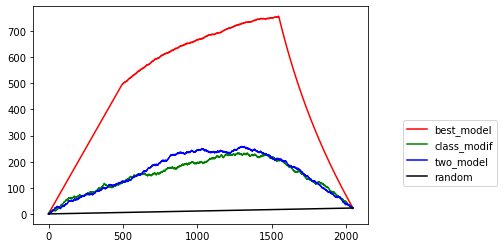

In [53]:
plot(np.arange(df.shape[0]),perfect_uc, color = 'r', label = 'best_model')
plot(np.arange(df.shape[0]),modified_uc, color =  'g', label = 'class_modif')
plot(np.arange(df.shape[0]),two_mod_uc, color = 'b', label = 'two_model')
plot(np.arange(df.shape[0]),rd,color = 'k', label = 'random')
plt.legend(bbox_to_anchor=(1.4, 0.5))

* Kriva uzdizanja je jednostavna generalizacija efekta uzdizanja po decilu.
* Što je veća površina ispod krive, to je bolji model - uporedivo sa AUC krivom.
* Pristup 2 modela ima bolje rezultate jer je konstantno viši.

### Qini krive

In [55]:
def qini(df, target_control_col, outcome_col, proba_col) :
    
    tmp = df.copy()
    tmp = tmp.sort_values(proba_col,ascending = False)
    tmp['RT'] = (tmp[target_control_col]*tmp[outcome_col]).cumsum()
    tmp['RC'] = ((1-tmp[target_control_col])*tmp[outcome_col]).cumsum()
    tmp['NT'] = tmp[target_control_col].cumsum()
    tmp['NC'] = (1-tmp[target_control_col]).cumsum()
    tmp['second_part'] = (tmp['RC'] * tmp['NT'] / tmp['NC']).fillna(0)
    tmp['qini'] = tmp['RT'] - tmp['second_part']
    
    return tmp['qini']

In [56]:
two_modqini = qini(df,'is_target','outcome','uplift_1')
modified_qini = qini(df,'is_target','outcome','uplift_2')
perfect_qini = qini(df,'is_target','outcome','perfect')
secpart = df[df['is_target']==0]['outcome'].sum() \
    * float(df[df['is_target']==1].shape[0])/df[df['is_target']==0].shape[0]
rqini = df[df['is_target']==1]['outcome'].sum() - secpart
rd = np.arange(len(perfect_qini)) * rqini / len(perfect_qini)

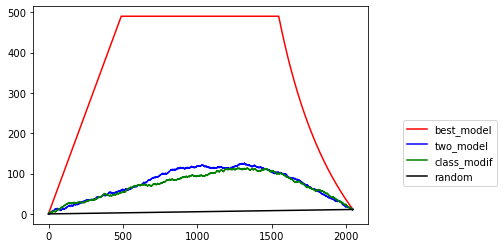

In [57]:
plot(np.arange(df.shape[0]),perfect_qini, color = 'r', label = 'best_model')
plot(np.arange(df.shape[0]),two_modqini, color =  'b', label = 'two_model')
plot(np.arange(df.shape[0]),modified_qini, color = 'g', label = 'class_modif')
plot(np.arange(df.shape[0]),rd,color = 'k', label = 'random')
plt.legend(bbox_to_anchor=(1.4, 0.5))

Zaključci:
* teoretski random model (crna linija) pokazuje sveukupno tretman ima mali pozitivan efekat (pozitivan ali nizak nagib)
* crvena kriva odgovara najboljem teorijskom modelu; što je bliže crvenoj krivini to bolje
* pristup dva modela ima bolji učinak od drugog pristupa pošto je njegova kriva konstantno viša

Međutim ima mesta za poboljšanje jer smo u oba slučaja daleko od crvene linije.